In [1]:
import os
import librosa
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
from scipy.stats import skew
import cv2 #pip install opencv-python
from scipy.optimize import minimize
import librosa                    
import librosa.display


import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score

#!pip install lightgbm
#import lightgbm as lgbm

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVC

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
Initial shape: (288, 432)


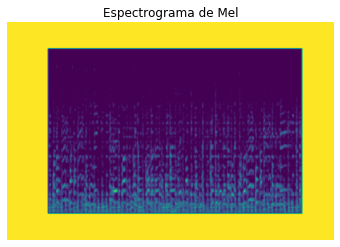

In [2]:
IMG = './data/images_original/'
#IMG = './dataset/'
img_dataset = []
genre_target = []
genres = {}
classes = []
i = 0
for root, dirs, files in os.walk(IMG):
    for name in files:
        filename = os.path.join(root, name)
        img_dataset.append(filename)
        genre = filename.split('\\')[0].split('/')[-1]
        genre_target.append(genre)
        
        if(genre not in genres):
            classes.append(genre)
            genres[genre] = i
            i+=1

print(classes)

img = cv2.imread(img_dataset[0],0)
print("Initial shape:",img.shape)

plt.imshow(img, interpolation = 'bicubic', cmap='viridis')
plt.title("Espectrograma de Mel")
plt.axis('off')
plt.show()

In [3]:
def crop_borders(img,x1=35,x2=252,y1=54,y2=389):
    cropped = img[x1:x2,y1:y2]
    return cropped

def get_y():
    '''Convierte los generos en un array de targets y'''
    y = []
    for genre in genre_target:
        n = genres[genre]
        y.append(n)
    return np.array(y)

def get_x(shape=[999,217*335], flag=0):
    x = np.empty(shape, np.uint8)
    for i in range(len(img_dataset)):
        img = cv2.imread(img_dataset[i],flag)
        img = crop_borders(img)
        #img = crop_borders(img,x1=50,x2=252,y1=54,y2=244)
        x[i] = img.ravel()
    return np.array(x).T

Shape: (217, 335)


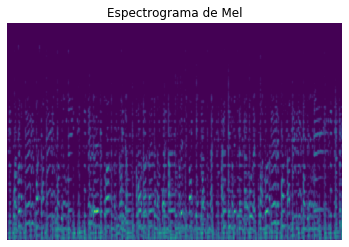

In [4]:
img = cv2.imread(img_dataset[0],0)
img = crop_borders(img)
#img = crop_borders(img,x1=50,x2=252,y1=54,y2=244) #crop to low scale
print("Shape:",img.shape)

plt.imshow(img, interpolation = 'bicubic', cmap='viridis')
plt.title("Espectrograma de Mel")
plt.axis('off')
plt.show()

In [5]:
X = get_x(shape=[999,img.ravel().shape[0]]).T
y = get_y()

m = len(y)
num_labels = 10

print(X.shape, y.shape)

(999, 72695) (999,)


In [6]:
def one_hot(y, m, num_labels):
    '''one hot encoding'''
    y_onehot = np.zeros((m, num_labels))  # 5000 x 10
    for i in range(m):
        y_onehot[i][y[i]] = 1
    return y_onehot

y_onehot = one_hot(y, m, num_labels) #cambiar por OneHot de Sklearn

In [7]:
# Helper to plot confusion matrix -- from Scikit-learn website
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig = plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(genres))
    plt.xticks(tick_marks, genres, rotation=45)
    #plt.yticks(tick_marks, genres)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [8]:
def extract_features(image_path, vector_size=32):
    image = cv2.imread(image_path, 1)
    image = crop_borders(image)
    try:
        # Using KAZE, cause SIFT, ORB and other was moved to additional module
        # which is adding addtional pain during install
        alg = cv2.KAZE_create()
        # Dinding image keypoints
        kps = alg.detect(image)
        # Getting first 32 of them. 
        # Number of keypoints is varies depend on image size and color pallet
        # Sorting them based on keypoint response value(bigger is better)
        kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
        # computing descriptors vector
        kps, dsc = alg.compute(image, kps)
        # Flatten all of them in one big vector - our feature vector
        dsc = dsc.flatten()
        # Making descriptor of same size
        # Descriptor vector size is 64
        needed_size = (vector_size * 64)
        if dsc.size < needed_size:
            # if we have less the 32 descriptors then just adding zeros at the
            # end of our feature vector
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
    except cv2.error as e:
        print ('Error: ', e)
        return None

    return dsc

img_features = extract_features(img_dataset[9])
i = 0

X_KAZE = np.empty([999,img_features.shape[0]], np.float32)

for f in img_dataset:
    if i % 100 == 0:
        print ('Extracting features from folder %s' % f.split('/')[3].split('\\')[0])
    X_KAZE[i] =  extract_features(f)
    i += 1
    
    
X_KAZE.shape

Extracting features from folder blues
Extracting features from folder classical
Extracting features from folder country
Extracting features from folder disco
Extracting features from folder hiphop
Extracting features from folder jazz
Extracting features from folder metal
Extracting features from folder pop
Extracting features from folder reggae
Extracting features from folder rock


(999, 2048)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_KAZE, y, stratify=y)

print(X.shape, X_train.shape, X_test.shape)

(999, 72695) (749, 2048) (250, 2048)


In [10]:
params = {
    "cls__C": [0.5, 1, 2, 5],
    "cls__kernel": ['rbf', 'linear', 'sigmoid'],
}

pipe_svm = Pipeline([
    ('scale', StandardScaler()),
    ('cls', SVC())
])

grid_svm = GridSearchCV(pipe_svm, params, scoring='accuracy', n_jobs=6, cv=5,verbose=50)
grid_svm.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    6.9s
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:    7.0s
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:    7.0s
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:    7.0s
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:    7.0s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    7.8s
[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:   10.0s
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:   10.1s
[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:   10.1s
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:   10.1s
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:   10.1s
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:   10.8s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:   13.3s
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:   13.5s
[Parallel(

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('cls',
                                        SVC(C=1.0, cache_size=200,
                                            class_weight=None, coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='auto_deprecated',
                                            kernel='rbf', max_iter=-1,
                                            probability=False,
                                            random_state=None, shrinking=True,
                                            tol=0.001, verbose=False))],
                 

In [11]:
preds = grid_svm.predict(X_test)
print("best score on validation set with KAZE (accuracy) = {:.4f}".format(grid_svm.best_score_))
print("best score on test set with KAZE (accuracy) = {:.4f}".format(accuracy_score(y_test, preds)))

best score on validation set with KAZE (accuracy) = 0.3218
best score on test set with KAZE (accuracy) = 0.2960


In [12]:
cm = confusion_matrix(y_test, preds)

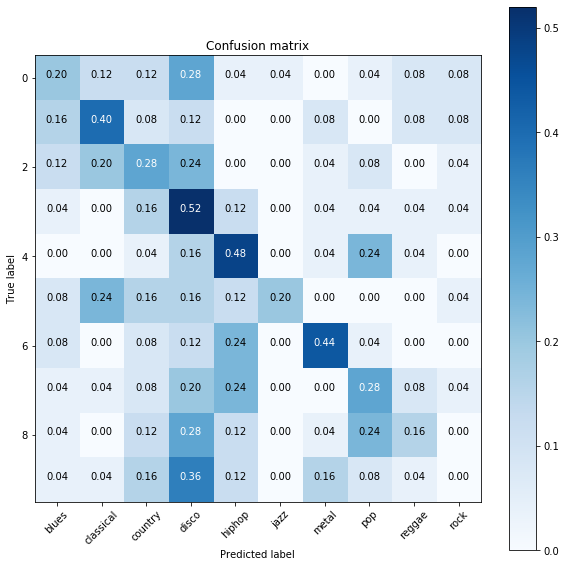

In [13]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes, normalize=True)

In [1]:
genres_pred = {}
for k,v in genres.items():
    genres_pred[v] = k
    
genres_pred

files = os.listdir(os.path('./test_songs/images/'))
songs = [ img for img in files if img.split('.')[-1] == 'png']

NameError: name 'genres' is not defined

In [15]:
for song in songs:
    #img = cv2.imread(song,0)
    #img = crop_borders(img)
    #img = crop_borders(img,x1=50,x2=252,y1=144,y2=244)
    img = extract_features(song)
    mel = img.ravel()
    pred = grid_svm.predict(mel.reshape(1, -1))
    print(song)
    print(genres_pred[int(pred)])

abba.png
classical
desakato.png
hiphop
elfinde.png
country
iseo.png
hiphop
metallica.png
reggae
sultans.png
country


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

print(X.shape, X_train.shape, X_test.shape)

(999, 72695) (749, 72695) (250, 72695)


In [17]:
params = {
    "cls__C": [0.5, 1, 2, 5],
    "cls__kernel": ['rbf', 'linear', 'sigmoid'],
}

pipe_svm = Pipeline([
    ('scale', StandardScaler()),
    ('cls', SVC())
])

grid_svm = GridSearchCV(pipe_svm, params, scoring='accuracy', n_jobs=6, cv=5,verbose=50)
grid_svm.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:  4.4min
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:  4.4min
[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:  4.4min
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:  4.5min
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:  4.5min
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:  4.5min
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  6.5min
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:  6.5min
[Parallel(

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('cls',
                                        SVC(C=1.0, cache_size=200,
                                            class_weight=None, coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='auto_deprecated',
                                            kernel='rbf', max_iter=-1,
                                            probability=False,
                                            random_state=None, shrinking=True,
                                            tol=0.001, verbose=False))],
                 

In [18]:
preds = grid_svm.predict(X_test)
print("best score on validation set (accuracy) = {:.4f}".format(grid_svm.best_score_))
print("best score on test set (accuracy) = {:.4f}".format(accuracy_score(y_test, preds)))

best score on validation set (accuracy) = 0.4927
best score on test set (accuracy) = 0.5520


In [19]:
cm = confusion_matrix(y_test, preds)

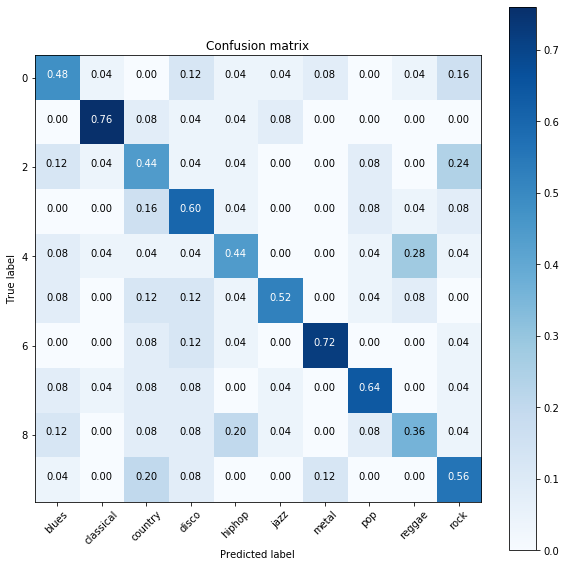

In [20]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes, normalize=True)

In [21]:
genres_pred = {}
for k,v in genres.items():
    genres_pred[v] = k
    
genres_pred

files = os.listdir(os.curdir)
songs = [ img for img in files if img.split('.')[-1] == 'png']

In [22]:
for song in songs:
    img = cv2.imread(song,0)
    #img = crop_borders(img)
    #img = crop_borders(img,x1=50,x2=252,y1=144,y2=244)
    #img = extract_features(song)
    mel = img.ravel()
    pred = grid_svm.predict(mel.reshape(1, -1))
    print(song)
    print(genres_pred[int(pred)])

abba.png
rock
desakato.png
pop
elfinde.png
hiphop
iseo.png
pop
metallica.png
hiphop
sultans.png
country
